# Time Series Analysis☁️☀️⛱️⏰

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams['figure.figsize'] = (20,6)
import warnings
warnings.simplefilter(action='ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults,ARMA,ARMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import ar_select_order
import statsmodels.api as sm
import statsmodels
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa import stattools

# 1) Gather Data✨

In [2]:
with open("TG_STAID002759.txt", "r") as f:
    l=f.readlines()
l

['EUROPEAN CLIMATE ASSESSMENT & DATASET (ECA&D), file created on 20-02-2022\n',
 'THESE DATA CAN BE USED FREELY PROVIDED THAT THE FOLLOWING SOURCE IS ACKNOWLEDGED:\n',
 '\n',
 'Klein Tank, A.M.G. and Coauthors, 2002. Daily dataset of 20th-century surface\n',
 'air temperature and precipitation series for the European Climate Assessment.\n',
 'Int. J. of Climatol., 22, 1441-1453.\n',
 'Data and metadata available at http://www.ecad.eu\n',
 '\n',
 'FILE FORMAT (MISSING VALUE CODE IS -9999):\n',
 '\n',
 '01-06 SOUID: Source identifier\n',
 '08-15 DATE : Date YYYYMMDD\n',
 '17-21 TG   : mean temperature in 0.1 &#176;C\n',
 "23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')\n",
 '\n',
 'This is the blended series of station GERMANY, BERLIN-TEMPELHOF (STAID: 2759).\n',
 'Blended and updated with sources: 111448 127488 128124 \n',
 'See file sources.txt and stations.txt for more info.\n',
 '\n',
 ' SOUID,    DATE,   TG, Q_TG\n',
 '127488,18760101,   22,    0\n',
 '127488,

In [3]:
for i in range(10,14):
    print(l[i])

01-06 SOUID: Source identifier

08-15 DATE : Date YYYYMMDD

17-21 TG   : mean temperature in 0.1 &#176;C

23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')



In [4]:
df=pd.read_csv('TG_STAID002759.txt', skiprows=19)
df.columns = df.columns.str.strip()
df

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0
...,...,...,...,...
53352,111448,20220127,44,0
53353,111448,20220128,49,0
53354,111448,20220129,58,0
53355,111448,20220130,58,0


In [5]:
df.columns

Index(['SOUID', 'DATE', 'TG', 'Q_TG'], dtype='object')

In [6]:
df['DATE']=df['DATE'].astype(str)

In [7]:
df['DATE']=pd.to_datetime(df['DATE'])

In [8]:
df=df.set_index('DATE')


In [9]:
df

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0
...,...,...,...
2022-01-27,111448,44,0
2022-01-28,111448,49,0
2022-01-29,111448,58,0


# 2) Explore the data


In [10]:
df.dtypes

SOUID    int64
TG       int64
Q_TG     int64
dtype: object

In [11]:
df[df['Q_TG']==9].value_counts()

SOUID   TG     Q_TG
127488  -9999  9       195
dtype: int64

In [12]:
#converting to C
df['TG']=df['TG']*0.1

In [13]:
df

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,2.2,0
1876-01-02,127488,2.5,0
1876-01-03,127488,0.3,0
1876-01-04,127488,-5.8,0
1876-01-05,127488,-9.8,0
...,...,...,...
2022-01-27,111448,4.4,0
2022-01-28,111448,4.9,0
2022-01-29,111448,5.8,0


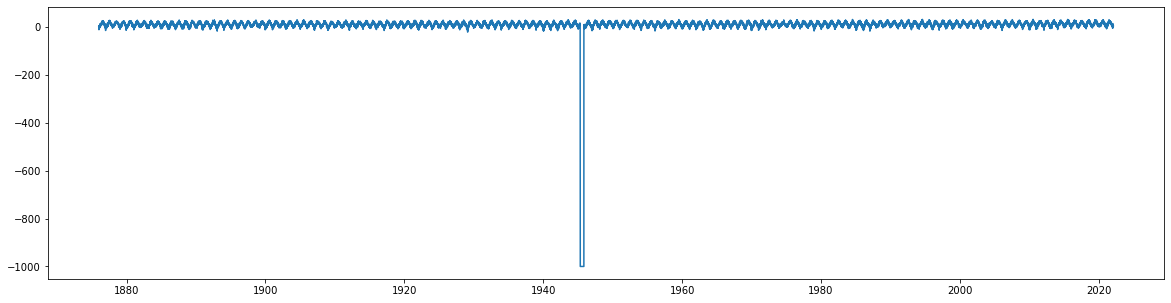

In [14]:
plt.subplots(figsize=(20,5))
plt.plot(df.index.values,df['TG'])
plt.show()

# 3) Selection of datetime range

In [15]:
#select 1970-2020 as our data
df_new=df.loc['1970-01-01':'2020-12-31'].drop(['Q_TG','SOUID'],axis=1)

In [16]:
df_feat=df.loc['2021-01-01':].drop(['Q_TG','SOUID'],axis=1)
df_feat.to_pickle('df_feat.pkl') #  saving fro forcast

In [17]:
df_new

,TG
DATE,
1970-01-01,-12.8
1970-01-02,-4.9
1970-01-03,-1.4
1970-01-04,-4.4
1970-01-05,-3.0
...,...
2020-12-27,1.6
2020-12-28,2.8
2020-12-29,2.3


# 4) Selecting Train and Test data

In [18]:
df_train=df_new.loc['1970-01-01':'2010-12-31'] ##40 years for train data
df_test=df_new.loc['2011-01-01':'2020-12-31']## 10 years for test data

<AxesSubplot:xlabel='DATE'>

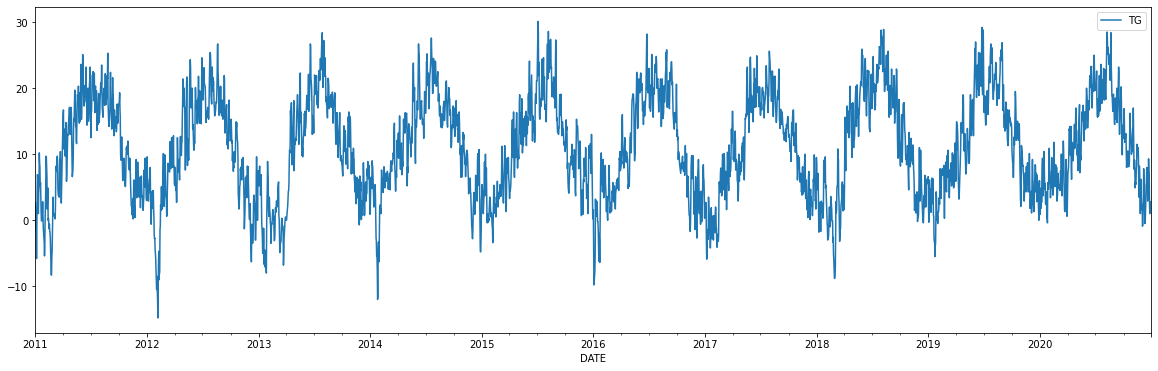

In [19]:
df_test.plot()

In [20]:
df_test.to_pickle('df_test.pkl')

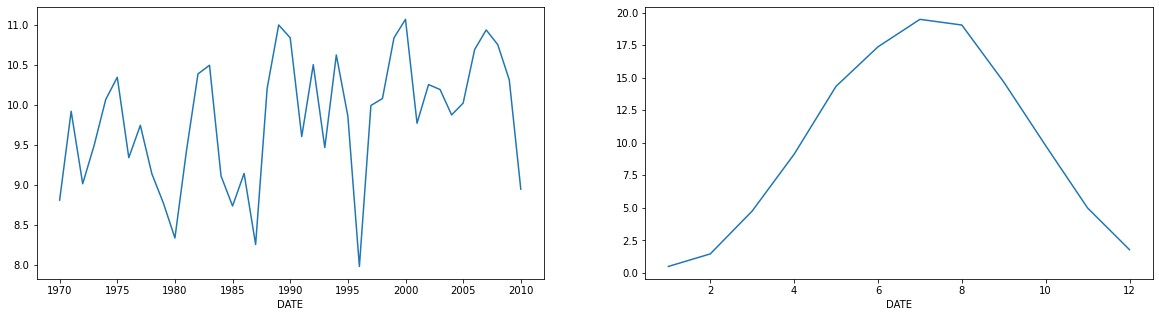

In [21]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20, 5)
df_train.groupby(df_train.index.year)['TG'].mean().plot(ax=ax1)
df_train.groupby(df_train.index.month)['TG'].mean().plot(ax=ax2)
plt.show()

# 5) Decompose

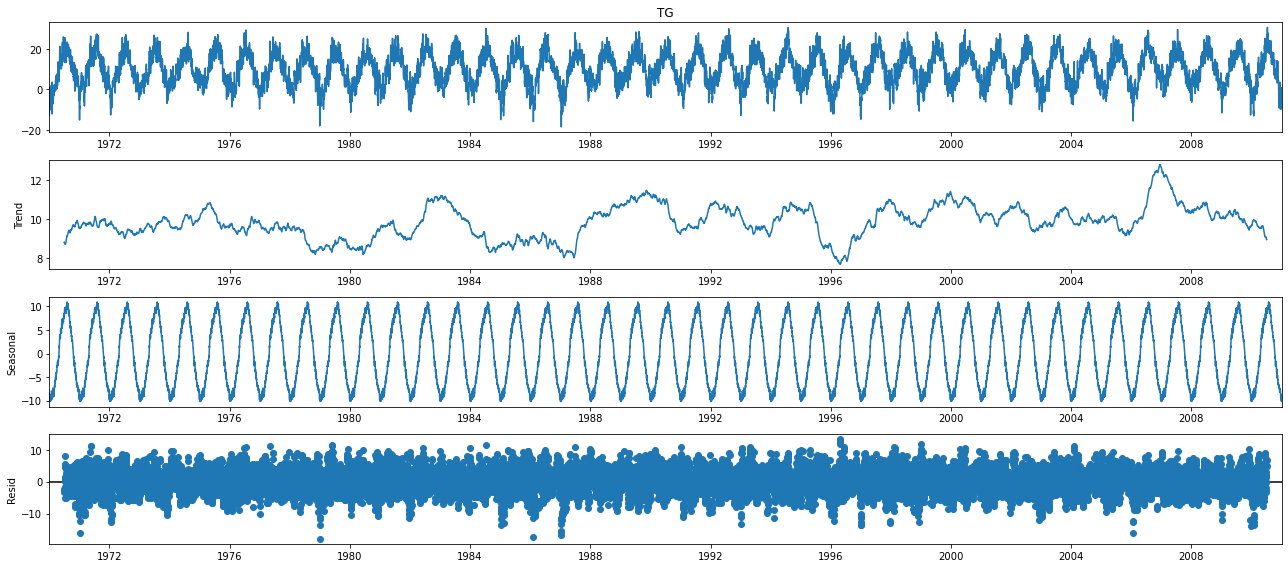

In [22]:
plt.rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_train['TG'], model='additive',period=365)
fig = decomposition.plot()
plt.show()

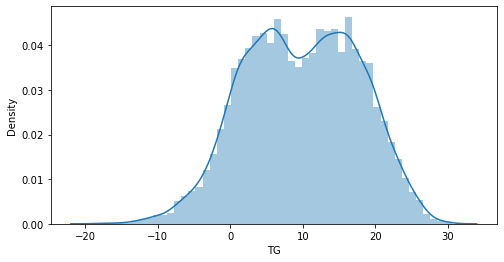

In [23]:
plt.figure(figsize=(8,4))
sns.distplot(df_train["TG"])
plt.show()

# 6) Modeling trend and seasonality and extracting remainder

In [24]:
# create timestep variable to model the trend using LR
df_train['timestep'] = list(range(len(df_train)))


In [25]:
#Model the seasonality
# make dummy columns for months
seasonal_dummies = pd.get_dummies(df_train.index.month_name(), drop_first=True).set_index(df_train.index)

In [26]:
df_train = df_train.join(seasonal_dummies)
df_train.head()

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September
DATE,,,,,,,,,,,,,
1970-01-01,-12.8,0,0,0,0,1,0,0,0,0,0,0,0
1970-01-02,-4.9,1,0,0,0,1,0,0,0,0,0,0,0
1970-01-03,-1.4,2,0,0,0,1,0,0,0,0,0,0,0
1970-01-04,-4.4,3,0,0,0,1,0,0,0,0,0,0,0
1970-01-05,-3.0,4,0,0,0,1,0,0,0,0,0,0,0


In [27]:
# model seaonality and trend
m_seas_trend = LinearRegression()

In [28]:
# set timestep as X and map to y

y = df_train['TG']
X=df_train.drop(columns=['TG'])
m_seas_trend.fit(X, y)
df_train['seasonal_trend'] = m_seas_trend.predict(X)
df_train

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September,seasonal_trend
DATE,,,,,,,,,,,,,,
1970-01-01,-12.8,0,0,0,0,1,0,0,0,0,0,0,0,-0.033065
1970-01-02,-4.9,1,0,0,0,1,0,0,0,0,0,0,0,-0.032993
1970-01-03,-1.4,2,0,0,0,1,0,0,0,0,0,0,0,-0.032921
1970-01-04,-4.4,3,0,0,0,1,0,0,0,0,0,0,0,-0.032849
1970-01-05,-3.0,4,0,0,0,1,0,0,0,0,0,0,0,-0.032778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-27,-3.2,14970,0,1,0,0,0,0,0,0,0,0,0,2.302959
2010-12-28,-6.5,14971,0,1,0,0,0,0,0,0,0,0,0,2.303030
2010-12-29,-8.8,14972,0,1,0,0,0,0,0,0,0,0,0,2.303102


<AxesSubplot:xlabel='DATE'>

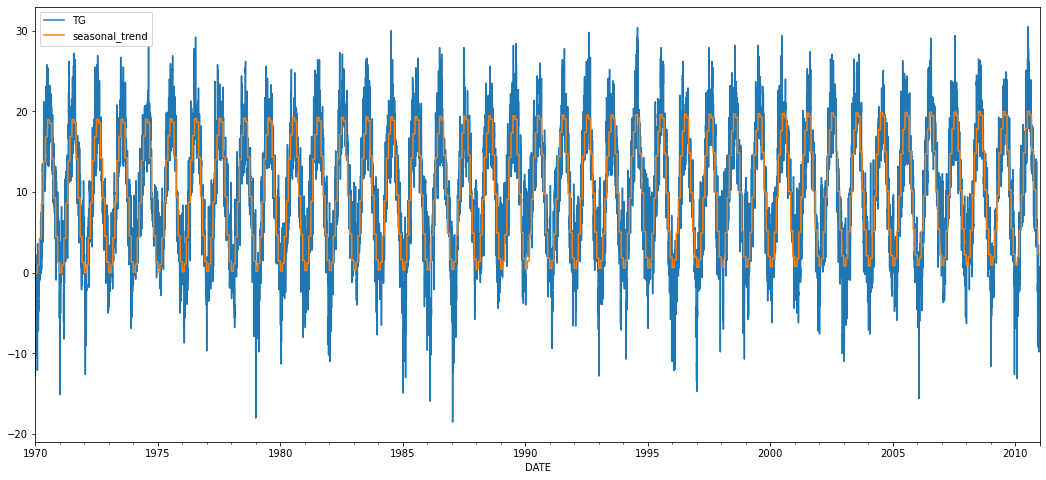

In [29]:
df_train
df_train[['TG', 'seasonal_trend']].plot()

In [30]:
df_train

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September,seasonal_trend
DATE,,,,,,,,,,,,,,
1970-01-01,-12.8,0,0,0,0,1,0,0,0,0,0,0,0,-0.033065
1970-01-02,-4.9,1,0,0,0,1,0,0,0,0,0,0,0,-0.032993
1970-01-03,-1.4,2,0,0,0,1,0,0,0,0,0,0,0,-0.032921
1970-01-04,-4.4,3,0,0,0,1,0,0,0,0,0,0,0,-0.032849
1970-01-05,-3.0,4,0,0,0,1,0,0,0,0,0,0,0,-0.032778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-27,-3.2,14970,0,1,0,0,0,0,0,0,0,0,0,2.302959
2010-12-28,-6.5,14971,0,1,0,0,0,0,0,0,0,0,0,2.303030
2010-12-29,-8.8,14972,0,1,0,0,0,0,0,0,0,0,0,2.303102


In [31]:
#Extract the remainder
df_train['remainder']=df_train['TG']-df_train['seasonal_trend']
df_train['remainder']


DATE
1970-01-01   -12.766935
1970-01-02    -4.867007
1970-01-03    -1.367079
1970-01-04    -4.367151
1970-01-05    -2.967222
                ...    
2010-12-27    -5.502959
2010-12-28    -8.803030
2010-12-29   -11.103102
2010-12-30   -11.803174
2010-12-31    -1.603246
Name: remainder, Length: 14975, dtype: float64

<AxesSubplot:xlabel='DATE'>

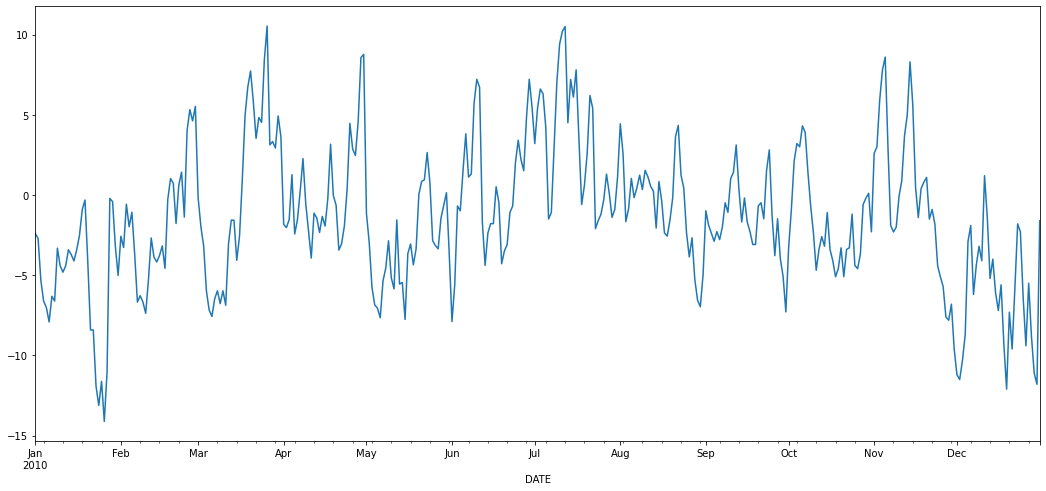

In [32]:
df_train[df_train.index.year==2010]['remainder'].plot()

In [33]:
df_train['remainder'].to_csv('TG_remainder.csv')

# 7) Dickey Fuller Test

In [34]:
def perform_dickey_fuller_test(ts):
    result = adfuller(ts, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
perform_dickey_fuller_test(df_train['TG'])

ADF Statistic: -8.269133
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


We can see that our statistic value of -8.269133 is less than the value of -3.431 at 1%.

This suggests that we can reject the null hypothesis with a significance level of less than 1%.

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

# 8) Determination of number of lags


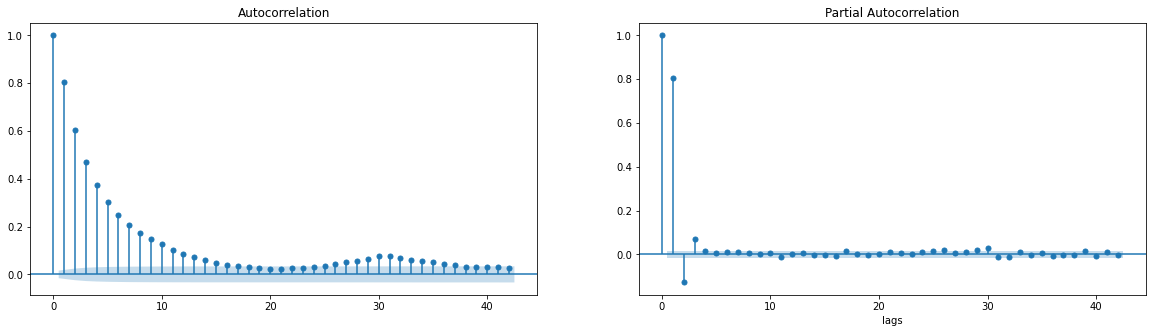

In [35]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20, 5)
plot_acf(df_train['remainder'],ax=ax1)
plot_pacf(df_train['remainder'],ax=ax2)

plt.xlabel('lags');

It shows that on ACP graph, exponential and slow decreased between relationships.
Eventhough, on PACF graph, the relationship is decreased slowly. For this reason , I selected to go on with Ar model.

In [36]:
selected_order = ar_select_order(df_train['remainder'], maxlag=12)
selected_order.ar_lags

/Users/burcakbal/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/burcakbal/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


array([1, 2, 3])

***Another method to understand that how many lags should I use***

In [37]:
def output(n):
    ar_model = AutoReg(endog=df_train['remainder'], lags = n).fit()
    return ar_model.summary()

In [38]:
output(1)

/Users/burcakbal/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                14975
Model:                     AutoReg(1)   Log Likelihood              -33992.403
Method:               Conditional MLE   S.D. of innovations              2.342
Date:                Fri, 25 Feb 2022   AIC                              1.703
Time:                        01:24:19   BIC                              1.704
Sample:                    01-02-1970   HQIC                             1.703
                         - 12-31-2010                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0008      0.019      0.040      0.968      -0.037       0.038
remainder.L1     0.8047      0.005    166.044      0.000       0.795       0.814
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2426           +0.0000j            1.2426            0.0000
-----------------------------------------------------------------------------
"""

In [39]:
output(2)

/Users/burcakbal/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                14975
Model:                     AutoReg(2)   Log Likelihood              -33862.077
Method:               Conditional MLE   S.D. of innovations              2.322
Date:                Fri, 25 Feb 2022   AIC                              1.686
Time:                        01:24:19   BIC                              1.688
Sample:                    01-03-1970   HQIC                             1.686
                         - 12-31-2010                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0004      0.019      0.022      0.982      -0.037       0.038
remainder.L1     0.9090      0.008    112.148      0.000       0.893       0.925
remainder.L2    -0.1292      0.008    -15.934      0.000      -0.145      -0.113
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3647           +0.0000j            1.3647            0.0000
AR.2            5.6738           +0.0000j            5.6738            0.0000
-----------------------------------------------------------------------------
"""

In [40]:
output(3)

/Users/burcakbal/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                14975
Model:                     AutoReg(3)   Log Likelihood              -33821.510
Method:               Conditional MLE   S.D. of innovations              2.316
Date:                Fri, 25 Feb 2022   AIC                              1.681
Time:                        01:24:19   BIC                              1.683
Sample:                    01-04-1970   HQIC                             1.682
                         - 12-31-2010                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0003      0.019      0.016      0.987      -0.037       0.037
remainder.L1     0.9182      0.008    112.600      0.000       0.902       0.934
remainder.L2    -0.1942      0.011    -17.704      0.000      -0.216      -0.173
remainder.L3     0.0717      0.008      8.800      0.000       0.056       0.088
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2703           -0.0000j            1.2703           -0.0000
AR.2            0.7184           -3.2337j            3.3125           -0.2152
AR.3            0.7184           +3.2337j            3.3125            0.2152
-----------------------------------------------------------------------------
"""

In [41]:
#saving remainder
df_train.to_pickle('df_train.pkl')

# 9) Autoregressive Model - AR(3) on Train data

In [42]:
#Create time-lagged input features
df_train['lag1'] = df_train['remainder'].shift(1)
df_train['lag2'] = df_train['remainder'].shift(2)
df_train['lag3'] = df_train['remainder'].shift(3)
df_train

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September,seasonal_trend,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,
1970-01-01,-12.8,0,0,0,0,1,0,0,0,0,0,0,0,-0.033065,-12.766935,NaN,NaN,NaN
1970-01-02,-4.9,1,0,0,0,1,0,0,0,0,0,0,0,-0.032993,-4.867007,-12.766935,NaN,NaN
1970-01-03,-1.4,2,0,0,0,1,0,0,0,0,0,0,0,-0.032921,-1.367079,-4.867007,-12.766935,NaN
1970-01-04,-4.4,3,0,0,0,1,0,0,0,0,0,0,0,-0.032849,-4.367151,-1.367079,-4.867007,-12.766935
1970-01-05,-3.0,4,0,0,0,1,0,0,0,0,0,0,0,-0.032778,-2.967222,-4.367151,-1.367079,-4.867007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-27,-3.2,14970,0,1,0,0,0,0,0,0,0,0,0,2.302959,-5.502959,-9.402887,-6.402815,-2.302744
2010-12-28,-6.5,14971,0,1,0,0,0,0,0,0,0,0,0,2.303030,-8.803030,-5.502959,-9.402887,-6.402815
2010-12-29,-8.8,14972,0,1,0,0,0,0,0,0,0,0,0,2.303102,-11.103102,-8.803030,-5.502959,-9.402887


In [43]:
df_train.dropna(inplace=True)
df_train.head()

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September,seasonal_trend,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,
1970-01-04,-4.4,3,0,0,0,1,0,0,0,0,0,0,0,-0.032849,-4.367151,-1.367079,-4.867007,-12.766935
1970-01-05,-3.0,4,0,0,0,1,0,0,0,0,0,0,0,-0.032778,-2.967222,-4.367151,-1.367079,-4.867007
1970-01-06,-4.7,5,0,0,0,1,0,0,0,0,0,0,0,-0.032706,-4.667294,-2.967222,-4.367151,-1.367079
1970-01-07,-7.1,6,0,0,0,1,0,0,0,0,0,0,0,-0.032634,-7.067366,-4.667294,-2.967222,-4.367151
1970-01-08,-10.2,7,0,0,0,1,0,0,0,0,0,0,0,-0.032563,-10.167437,-7.067366,-4.667294,-2.967222


<AxesSubplot:>

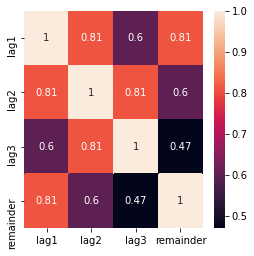

In [44]:
plt.figure(figsize=(4,4))
sns.heatmap(round(df_train[['lag1','lag2','lag3', 'remainder']].corr(), 2), annot=True)

<AxesSubplot:xlabel='lag3', ylabel='remainder'>

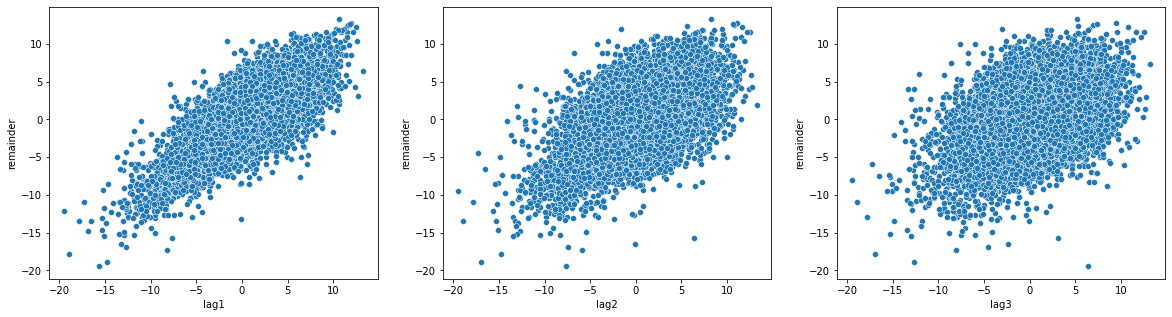

In [45]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(20, 5)

sns.scatterplot(x='lag1', y='remainder', data=df_train,ax=ax1)
sns.scatterplot(x='lag2', y='remainder', data=df_train,ax=ax2)
sns.scatterplot(x='lag3', y='remainder', data=df_train,ax=ax3)

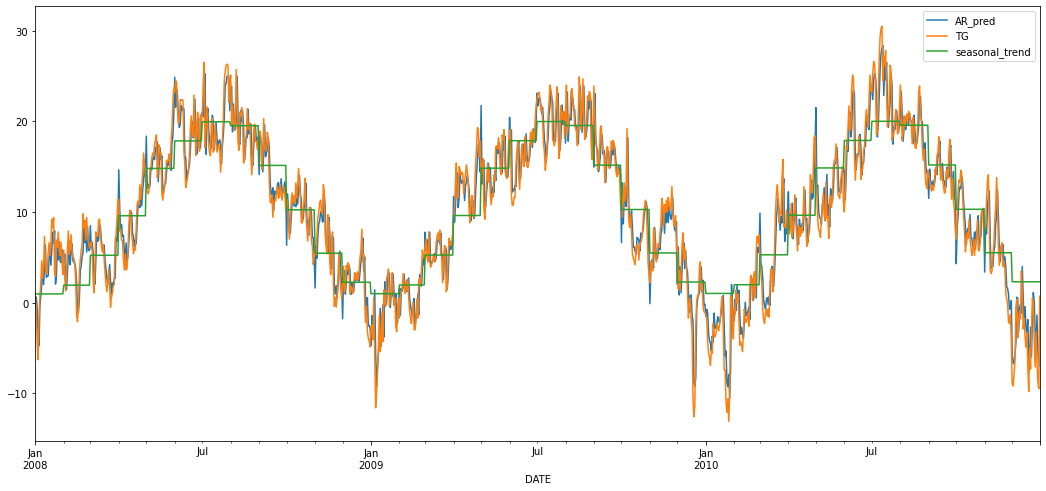

In [46]:
# Define X and y
X = df_train.drop(columns=['TG', 'seasonal_trend', 'remainder'])
y = df_train['TG']

# Train the model
m_AR= LinearRegression()
m_AR.fit(X, y)

# Create a new predictions column for the AR_prediction
df_train['AR_pred'] = m_AR.predict(X)

df_train[df_train.index.year>=2008][['AR_pred','TG','seasonal_trend']].plot();

### AR with `statsmodels`

In [47]:
from statsmodels.tsa.ar_model import AutoReg

In [48]:
ar_model = AutoReg(endog=df_train['remainder'], lags=3).fit()

/Users/burcakbal/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [49]:
df_train['ar_prediction'] = ar_model.predict()

<AxesSubplot:xlabel='DATE'>

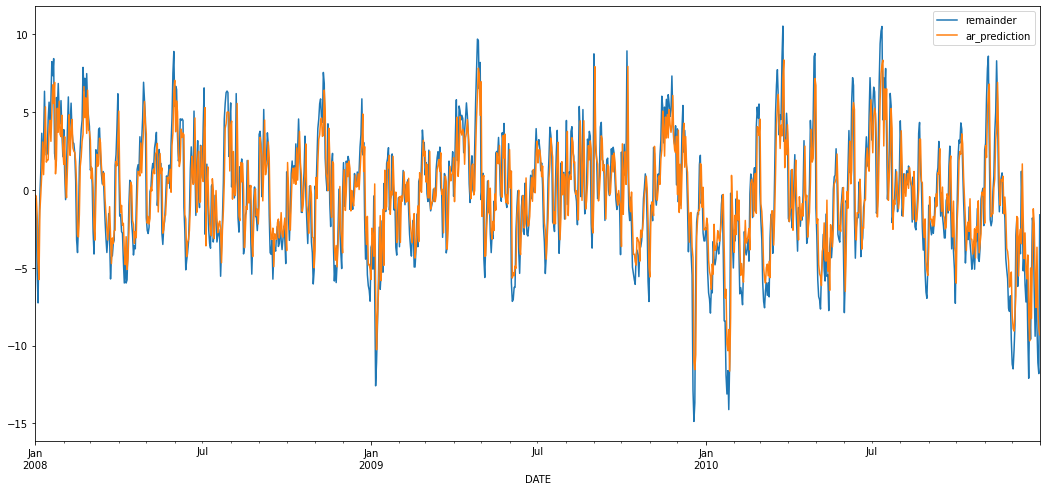

In [50]:
#df_train[df_train.index.year>=2008][['remainder', 'ar_prediction']].plot()

In [51]:
df_train['full_prediction_ar'] = df_train['seasonal_trend'] + df_train['ar_prediction']

<AxesSubplot:xlabel='DATE'>

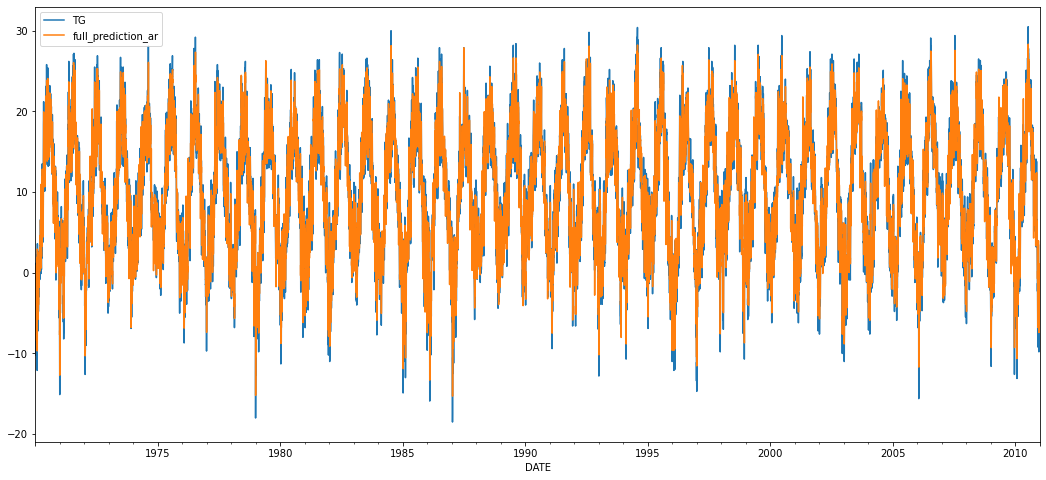

In [52]:
df_train[['TG', 'full_prediction_ar']].plot()

### 9) ARIMA with `statsmodels`

In [106]:
import pmdarima as pm

In [107]:
m = pm.auto_arima(df_train['TG'], 
                  seasonal=False, 
                  maxiter=10000, 
                  m=12, 
                  d=1,
                  D=1)

In [108]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                14969
Model:               SARIMAX(1, 1, 2)   Log Likelihood              -33680.585
Date:                Fri, 25 Feb 2022   AIC                          67369.170
Time:                        11:37:38   BIC                          67399.625
Sample:                             0   HQIC                         67379.276
                              - 14969                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6082      0.015     41.594      0.000       0.579       0.637
ma.L1         -0.6349      0.015    -42.227      0.000      -0.664      -0.605
ma.L2         -0.2154      0.009    -24.100      0.000      -0.233      -0.198
sigma2         5.2722      0.053     99.982      0.000       5.169       5.376
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               426.24
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                            -0.08
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [109]:
from statsmodels.tsa.arima.model import ARIMA

In [110]:
arima_model = ARIMA(df_train['remainder'], order=(1, 1, 2)).fit()

/Users/burcakbal/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/burcakbal/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/burcakbal/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [111]:
df_train['arima_prediction'] = arima_model.predict()

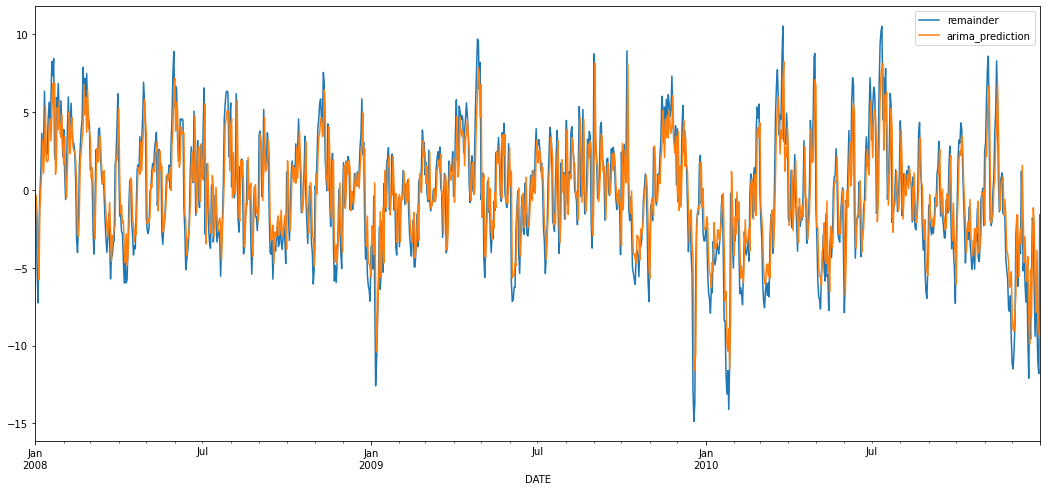

In [112]:
df_train[df_train.index.year>=2008][['remainder', 'arima_prediction']].plot();

In [113]:
df_train['full_prediction_arima'] = df_train['seasonal_trend'] + df_train['arima_prediction']

<AxesSubplot:xlabel='DATE'>

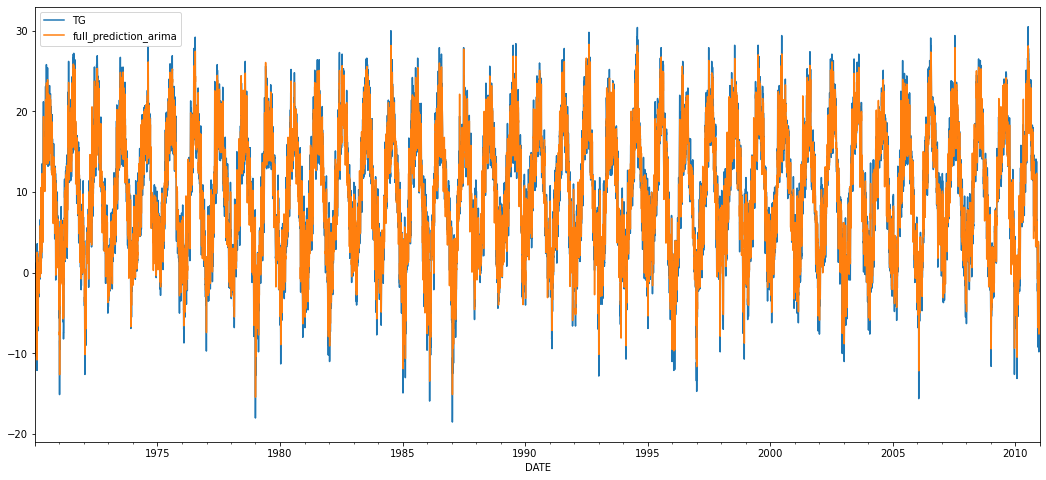

In [114]:
df_train[['TG', 'full_prediction_arima']].plot()

In [115]:
from sklearn.metrics import mean_squared_error as mse

In [116]:
df_train.dropna(inplace=True)

In [117]:
df_train['TG'].isnull().sum()

0

In [118]:
err_ar=mse(df_train['TG'],df_train['full_prediction_ar'])
err_arima=mse(df_train['TG'],df_train['full_prediction_arima'])

In [119]:
print("ar model error:",err_ar)
print("arima model error:",err_arima)

ar model error: 5.365891171120692
arima model error: 5.383617746890392


# 10) Cross Validation

In [64]:
ts_split = TimeSeriesSplit(n_splits=5) # instanciate the class and give the k as input

time_cv = ts_split.split(X, y) # this is a python generator

In [65]:
for i, (train_index, validation_index) in enumerate(time_cv):
    print("The training data for iteration #{} are the observations steps  = {}".format(i+1, train_index))
    print("size of training data = {}".format(len(train_index)))
    print("The validation data for iteration #{} are the observations steps = {}".format(i+1, validation_index))
    print("size of validation data = {}".format(len(validation_index)))

The training data for iteration #1 are the observations steps  = [   0    1    2 ... 2494 2495 2496]
size of training data = 2497
The validation data for iteration #1 are the observations steps = [2497 2498 2499 ... 4989 4990 4991]
size of validation data = 2495
The training data for iteration #2 are the observations steps  = [   0    1    2 ... 4989 4990 4991]
size of training data = 4992
The validation data for iteration #2 are the observations steps = [4992 4993 4994 ... 7484 7485 7486]
size of validation data = 2495
The training data for iteration #3 are the observations steps  = [   0    1    2 ... 7484 7485 7486]
size of training data = 7487
The validation data for iteration #3 are the observations steps = [7487 7488 7489 ... 9979 9980 9981]
size of validation data = 2495
The training data for iteration #4 are the observations steps  = [   0    1    2 ... 9979 9980 9981]
size of training data = 9982
The validation data for iteration #4 are the observations steps = [ 9982  9983  9

In [66]:
time_cv = ts_split.split(X, y)

r_squared_scores_2 = cross_val_score(estimator=m_AR, X=X, y=y, cv=time_cv )

print(r_squared_scores_2)

print(r_squared_scores_2.mean())

[0.91221863 0.90089049 0.91010364 0.91506019 0.92303235]
0.9122610607279983


# 11) Apply our trained model on test data

In [67]:
last_train_timestep = df_train['timestep'][-1] ## or you can use max()
last_train_timestep

14974

In [68]:
df_test['timestep'] = list(range(14975,last_train_timestep + 1 + len(df_test)))


In [69]:
#Model the seasonality
# make dummy columns for months
seasonal_dummies_test = pd.get_dummies(df_test.index.month_name(), drop_first=True).set_index(df_test.index)
seasonal_dummies_test

,August,December,February,January,July,June,March,May,November,October,September
DATE,,,,,,,,,,,
2011-01-01,0,0,0,1,0,0,0,0,0,0,0
2011-01-02,0,0,0,1,0,0,0,0,0,0,0
2011-01-03,0,0,0,1,0,0,0,0,0,0,0
2011-01-04,0,0,0,1,0,0,0,0,0,0,0
2011-01-05,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0,1,0,0,0,0,0,0,0,0,0
2020-12-28,0,1,0,0,0,0,0,0,0,0,0
2020-12-29,0,1,0,0,0,0,0,0,0,0,0


In [70]:
df_test = df_test.join(seasonal_dummies_test)
df_test.head()

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September
DATE,,,,,,,,,,,,,
2011-01-01,2.7,14975,0,0,0,1,0,0,0,0,0,0,0
2011-01-02,0.6,14976,0,0,0,1,0,0,0,0,0,0,0
2011-01-03,-1.5,14977,0,0,0,1,0,0,0,0,0,0,0
2011-01-04,-1.6,14978,0,0,0,1,0,0,0,0,0,0,0
2011-01-05,-5.8,14979,0,0,0,1,0,0,0,0,0,0,0


In [71]:
###Add trend and seasonality prediction

X_test = df_test.drop('TG', axis=1)
X_test

,timestep,August,December,February,January,July,June,March,May,November,October,September
DATE,,,,,,,,,,,,
2011-01-01,14975,0,0,0,1,0,0,0,0,0,0,0
2011-01-02,14976,0,0,0,1,0,0,0,0,0,0,0
2011-01-03,14977,0,0,0,1,0,0,0,0,0,0,0
2011-01-04,14978,0,0,0,1,0,0,0,0,0,0,0
2011-01-05,14979,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,18623,0,1,0,0,0,0,0,0,0,0,0
2020-12-28,18624,0,1,0,0,0,0,0,0,0,0,0
2020-12-29,18625,0,1,0,0,0,0,0,0,0,0,0


In [72]:
df_test['seasonal_trend_test'] = m_seas_trend.predict(X_test)
df_test

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September,seasonal_trend_test
DATE,,,,,,,,,,,,,,
2011-01-01,2.7,14975,0,0,0,1,0,0,0,0,0,0,0,1.040739
2011-01-02,0.6,14976,0,0,0,1,0,0,0,0,0,0,0,1.040810
2011-01-03,-1.5,14977,0,0,0,1,0,0,0,0,0,0,0,1.040882
2011-01-04,-1.6,14978,0,0,0,1,0,0,0,0,0,0,0,1.040954
2011-01-05,-5.8,14979,0,0,0,1,0,0,0,0,0,0,0,1.041026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1.6,18623,0,1,0,0,0,0,0,0,0,0,0,2.564902
2020-12-28,2.8,18624,0,1,0,0,0,0,0,0,0,0,0,2.564974
2020-12-29,2.3,18625,0,1,0,0,0,0,0,0,0,0,0,2.565046


<AxesSubplot:xlabel='DATE'>

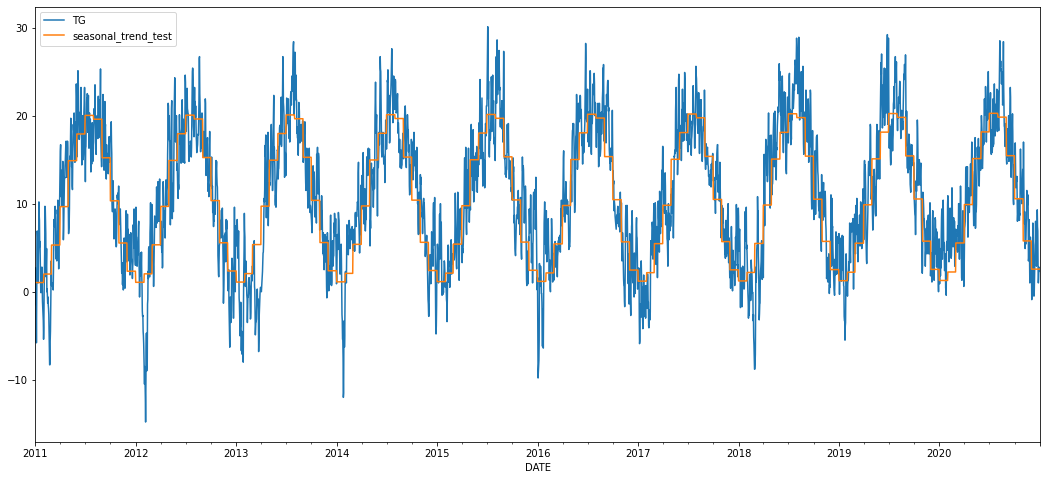

In [73]:
df_test[['TG', 'seasonal_trend_test']].plot()


***Calculate remainder and add lags***

In [74]:
df_test['remainder'] = df_test['TG'] - df_test['seasonal_trend_test']
df_test
# Calculate the reminder as our additional feature of AR model

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September,seasonal_trend_test,remainder
DATE,,,,,,,,,,,,,,,
2011-01-01,2.7,14975,0,0,0,1,0,0,0,0,0,0,0,1.040739,1.659261
2011-01-02,0.6,14976,0,0,0,1,0,0,0,0,0,0,0,1.040810,-0.440810
2011-01-03,-1.5,14977,0,0,0,1,0,0,0,0,0,0,0,1.040882,-2.540882
2011-01-04,-1.6,14978,0,0,0,1,0,0,0,0,0,0,0,1.040954,-2.640954
2011-01-05,-5.8,14979,0,0,0,1,0,0,0,0,0,0,0,1.041026,-6.841026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1.6,18623,0,1,0,0,0,0,0,0,0,0,0,2.564902,-0.964902
2020-12-28,2.8,18624,0,1,0,0,0,0,0,0,0,0,0,2.564974,0.235026
2020-12-29,2.3,18625,0,1,0,0,0,0,0,0,0,0,0,2.565046,-0.265046


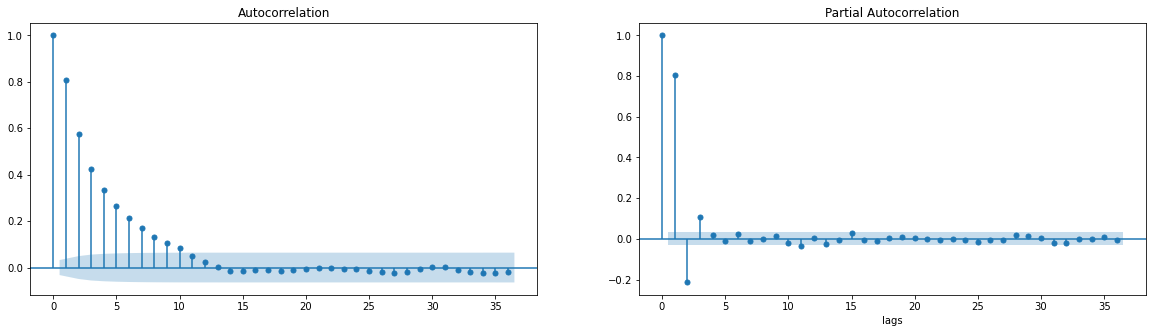

In [75]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20, 5)
plot_acf(df_test['remainder'],ax=ax1)
plot_pacf(df_test['remainder'],ax=ax2)

plt.xlabel('lags');

In [76]:
df_test['lag1'] = df_test['remainder'].shift(1)
df_test['lag2'] = df_test['remainder'].shift(2)
df_test['lag3'] = df_test['remainder'].shift(3)
df_test.head()

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September,seasonal_trend_test,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,
2011-01-01,2.7,14975,0,0,0,1,0,0,0,0,0,0,0,1.040739,1.659261,NaN,NaN,NaN
2011-01-02,0.6,14976,0,0,0,1,0,0,0,0,0,0,0,1.040810,-0.440810,1.659261,NaN,NaN
2011-01-03,-1.5,14977,0,0,0,1,0,0,0,0,0,0,0,1.040882,-2.540882,-0.440810,1.659261,NaN
2011-01-04,-1.6,14978,0,0,0,1,0,0,0,0,0,0,0,1.040954,-2.640954,-2.540882,-0.440810,1.659261
2011-01-05,-5.8,14979,0,0,0,1,0,0,0,0,0,0,0,1.041026,-6.841026,-2.640954,-2.540882,-0.440810


In [77]:
df_test.dropna(inplace=True)
df_test



,TG,timestep,August,December,February,January,July,June,March,May,November,October,September,seasonal_trend_test,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,
2011-01-04,-1.6,14978,0,0,0,1,0,0,0,0,0,0,0,1.040954,-2.640954,-2.540882,-0.440810,1.659261
2011-01-05,-5.8,14979,0,0,0,1,0,0,0,0,0,0,0,1.041026,-6.841026,-2.640954,-2.540882,-0.440810
2011-01-06,-0.1,14980,0,0,0,1,0,0,0,0,0,0,0,1.041097,-1.141097,-6.841026,-2.640954,-2.540882
2011-01-07,4.3,14981,0,0,0,1,0,0,0,0,0,0,0,1.041169,3.258831,-1.141097,-6.841026,-2.640954
2011-01-08,6.9,14982,0,0,0,1,0,0,0,0,0,0,0,1.041241,5.858759,3.258831,-1.141097,-6.841026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1.6,18623,0,1,0,0,0,0,0,0,0,0,0,2.564902,-0.964902,-1.564831,0.135241,4.335313
2020-12-28,2.8,18624,0,1,0,0,0,0,0,0,0,0,0,2.564974,0.235026,-0.964902,-1.564831,0.135241
2020-12-29,2.3,18625,0,1,0,0,0,0,0,0,0,0,0,2.565046,-0.265046,0.235026,-0.964902,-1.564831


In [78]:
# make AR model predictions

X_test = df_test.drop(['TG', 'seasonal_trend_test', 'remainder'], axis=1)
# Create the predictions
df_test['AR_pred'] = m_AR.predict(X_test)

df_test.head()

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September,seasonal_trend_test,remainder,lag1,lag2,lag3,AR_pred
DATE,,,,,,,,,,,,,,,,,,,
2011-01-04,-1.6,14978,0,0,0,1,0,0,0,0,0,0,0,1.040954,-2.640954,-2.540882,-0.440810,1.659261,-1.037282
2011-01-05,-5.8,14979,0,0,0,1,0,0,0,0,0,0,0,1.041026,-6.841026,-2.640954,-2.540882,-0.440810,-0.872639
2011-01-06,-0.1,14980,0,0,0,1,0,0,0,0,0,0,0,1.041097,-1.141097,-6.841026,-2.640954,-2.540882,-4.860388
2011-01-07,4.3,14981,0,0,0,1,0,0,0,0,0,0,0,1.041169,3.258831,-1.141097,-6.841026,-2.640954,1.180880
2011-01-08,6.9,14982,0,0,0,1,0,0,0,0,0,0,0,1.041241,5.858759,3.258831,-1.141097,-6.841026,3.811003


<AxesSubplot:xlabel='DATE'>

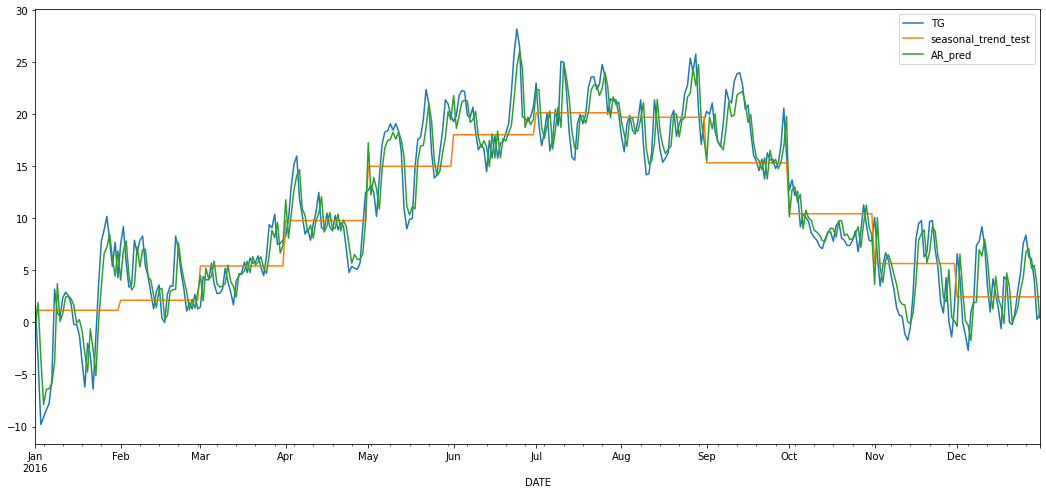

In [79]:
df_test[df_test.index.year==2016][['TG', 'seasonal_trend_test','AR_pred']].plot()


In [122]:
# let's check R squared score

print("R2 score Trend+Seasonality Model :",r2_score(df_test['TG'], df_test['seasonal_trend_test']))  # the score of the trend and season. model

print("R2 score AutoRegressive Model :",r2_score(df_test['TG'], df_test['AR_pred'])) # score of the full model

R2 score Trend+Seasonality Model : 0.7496073275717567
R2 score AutoRegressive Model : 0.918027263438397


In [81]:
print("MSE Trend+Seasonality Model :", mean_squared_error(df_test['TG'], df_test['seasonal_trend_test']))
print("MSE Autoregressive Model    :", mean_squared_error(df_test['TG'], df_test['AR_pred']))

MSE Trend+Seasonality Model : 14.653638317800288
MSE Autoregressive Model    : 4.797260326530883


## 12) Retrain the model on the whole data and Generate short term predictions


In [82]:
# join test and train data together

df_combined = df_train.append(df_test)
df_combined

,TG,timestep,August,December,February,January,July,June,March,May,...,remainder,lag1,lag2,lag3,AR_pred,ar_prediction,full_prediction_ar,arima_prediction,full_prediction_arima,seasonal_trend_test
DATE,,,,,,,,,,,,,,,,,,,,,
1970-01-07,-7.1,6,0,0,0,1,0,0,0,0,...,-7.067366,-4.667294,-2.967222,-4.367151,-4.005405,-4.021441,-4.054076,-4.021796,-4.054431,NaN
1970-01-08,-10.2,7,0,0,0,1,0,0,0,0,...,-10.167437,-7.067366,-4.667294,-2.967222,-5.777787,-5.795037,-5.827600,-5.831918,-5.864481,NaN
1970-01-09,-6.2,8,0,0,0,1,0,0,0,0,...,-6.167509,-10.167437,-7.067366,-4.667294,-8.280263,-8.297255,-8.329746,-8.295800,-8.328291,NaN
1970-01-10,-2.6,9,0,0,0,1,0,0,0,0,...,-2.567581,-6.167509,-10.167437,-7.067366,-4.179009,-4.193465,-4.225884,-4.190438,-4.222857,NaN
1970-01-11,0.9,10,0,0,0,1,0,0,0,0,...,0.932348,-2.567581,-6.167509,-10.167437,-1.873995,-1.886463,-1.918811,-1.862944,-1.895292,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1.6,18623,0,1,0,0,0,0,0,0,...,-0.964902,-1.564831,0.135241,4.335313,1.429917,NaN,NaN,NaN,NaN,2.564902
2020-12-28,2.8,18624,0,1,0,0,0,0,0,0,...,0.235026,-0.964902,-1.564831,0.135241,2.008225,NaN,NaN,NaN,NaN,2.564974
2020-12-29,2.3,18625,0,1,0,0,0,0,0,0,...,-0.265046,0.235026,-0.964902,-1.564831,2.870925,NaN,NaN,NaN,NaN,2.565046


In [83]:
# Re-train the model on the whole dataset
X_combined = df_combined.drop(columns=['TG', 'seasonal_trend', 'remainder', 'AR_pred','seasonal_trend_test','arima_prediction','full_prediction_ar','ar_prediction','full_prediction_arima'])
y_combined = df_combined['TG']
X_combined

,timestep,August,December,February,January,July,June,March,May,November,October,September,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,
1970-01-07,6,0,0,0,1,0,0,0,0,0,0,0,-4.667294,-2.967222,-4.367151
1970-01-08,7,0,0,0,1,0,0,0,0,0,0,0,-7.067366,-4.667294,-2.967222
1970-01-09,8,0,0,0,1,0,0,0,0,0,0,0,-10.167437,-7.067366,-4.667294
1970-01-10,9,0,0,0,1,0,0,0,0,0,0,0,-6.167509,-10.167437,-7.067366
1970-01-11,10,0,0,0,1,0,0,0,0,0,0,0,-2.567581,-6.167509,-10.167437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,18623,0,1,0,0,0,0,0,0,0,0,0,-1.564831,0.135241,4.335313
2020-12-28,18624,0,1,0,0,0,0,0,0,0,0,0,-0.964902,-1.564831,0.135241
2020-12-29,18625,0,1,0,0,0,0,0,0,0,0,0,0.235026,-0.964902,-1.564831


In [84]:
# Re-train the model on the whole dataset
m_AR_combined = LinearRegression()
m_AR_combined.fit(X_combined, y_combined)

LinearRegression()

In [85]:
df_combined.index.max()

Timestamp('2020-12-31 00:00:00')

In [86]:
#generate features for the time point 2021-01-01

X_future = []

timestep = df_combined['timestep'].max() + 1
months = [0]*3 + [1] + [0]*7   #dummy code for Jan
lag1 = df_combined.loc['2020-12-31', 'remainder'] 
lag2 = df_combined.loc['2020-12-31', 'lag1'] 
lag3 = df_combined.loc['2020-12-31', 'lag2'] 
print(timestep, months, lag1,lag2,lag3)

18628 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] 0.03481095172039117 -0.06511734188211982 -0.26504563548463134


In [87]:
X_future.append(timestep)
X_future.extend(months)
X_future.append(lag1)
X_future.append(lag2)
X_future.append(lag3)
print(X_future)

[18628, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0.03481095172039117, -0.06511734188211982, -0.26504563548463134]


In [88]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns

X_future

,timestep,August,December,February,January,July,June,March,May,November,October,September,lag1,lag2,lag3
0,18628,0,0,0,1,0,0,0,0,0,0,0,0.034811,-0.065117,-0.265046


In [89]:
print("Prediction for 2021-01-01 is {}".format(m_AR_combined.predict(X_future)[0]))


Prediction for 2021-01-01 is 1.4522763233740346


In [90]:
df.loc['2021-01-01']['TG']

2.1